8. Calculate the prediction accuracy of the models used in Experiment 7 and do comparative analysis among them to
identify the best technique.

   Car_ID    Brand    Model  Year  Kilometers_Driven Fuel_Type Transmission  \
0       1   Toyota  Corolla  2018              50000    Petrol       Manual   
1       2    Honda    Civic  2019              40000    Petrol    Automatic   
2       3     Ford  Mustang  2017              20000    Petrol    Automatic   
3       4   Maruti    Swift  2020              30000    Diesel       Manual   
4       5  Hyundai   Sonata  2016              60000    Diesel    Automatic   

  Owner_Type  Mileage  Engine  Power  Seats    Price  
0      First       15    1498    108      5   800000  
1     Second       17    1597    140      5  1000000  
2      First       10    4951    395      4  2500000  
3      Third       23    1248     74      5   600000  
4     Second       18    1999    194      5   850000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----

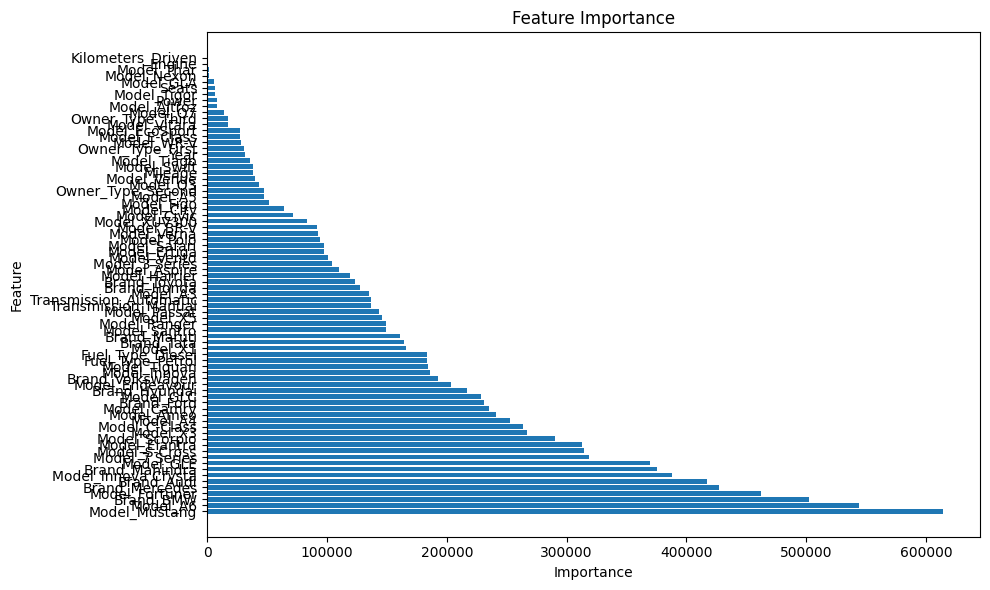

In [1]:
# Load your dataset here. Replace 'your_dataset.csv' with the path to your file.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression # Example regressor
from sklearn.impute import SimpleImputer # Example imputer

data = pd.read_csv('/content/cars.csv')

# Define features (X) and target (y)
X = data.drop('Price', axis=1)
y = data['Price']

# Define categorical and numerical features
categorical_features = ['Brand', 'Model', 'Fuel_Type', 'Transmission', 'Owner_Type']
numerical_features = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')) # Example: Impute missing numerical values
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the full pipeline including preprocessing and a regressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())]) # Example: Using Linear Regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 1: Display first few rows of the dataset
print(data.head())
# Step 2: Show dataset after cleaning and feature engineering (Note: Preprocessing happens within the pipeline)
print(data.info())
print(data.describe())
# Step 3: After Train-Test split, check shapes
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
# Step 4: Model Training Output
pipeline.fit(X_train, y_train)
print("Pipeline trained successfully!")
# Step 5: Training Performance
y_train_pred = pipeline.predict(X_train)
print("Training R-squared:", r2_score(y_train, y_train_pred))
print("Training Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
# Step 6: Testing Performance
y_test_pred = pipeline.predict(X_test)
print("Test R-squared:", r2_score(y_test, y_test_pred))
print("Test Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
# Step 7: Feature Importance Visualization

# Get feature names after preprocessing
# This part gets the feature names generated by the one-hot encoder
onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine numerical and one-hot encoded feature names
feature_names = numerical_features + list(onehot_features)

# Get importances from the trained model
regressor = pipeline.named_steps['regressor']
if hasattr(regressor, 'feature_importances_'):
    importances = regressor.feature_importances_
elif hasattr(regressor, 'coef_'):
    importances = abs(regressor.coef_) # Use absolute values of coefficients for linear models
else:
    print("Regressor does not have feature_importances_ or coef_ attribute.")
    importances = None

if importances is not None:
    plt.figure(figsize=(10, 6))
    # Ensure feature_names and importances have the same length and are sorted for plotting
    # For linear models, coef_ corresponds to the importance of each feature
    # We need to match these with the correct feature names after preprocessing
    # This requires careful handling of one-hot encoded features
    # As a simplified approach for Linear Regression, we'll assume the order matches after preprocessing
    # For more complex models like tree-based ones, feature_importances_ is directly available

    # Create a pandas Series for easier sorting and plotting
    importance_series = pd.Series(importances, index=feature_names)
    sorted_importance_series = importance_series.sort_values(ascending=False)

    plt.barh(sorted_importance_series.index, sorted_importance_series.values)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("Could not determine feature importances for the selected regressor.")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# Load the dataset
data = pd.read_csv(r'/content/cars.csv')
# Feature Engineering: Create 'car_age' and drop 'year'
data['car_age'] = 2024 - data['Year']
data.drop(columns=['Year', 'Brand', 'Model', 'Car_ID'], inplace=True)
# Split features and target variable
X = data.drop(columns='Price')
y = data['Price']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and model pipeline
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'car_age']),
('cat', OneHotEncoder(drop='first'), ['Fuel_Type', 'Transmission', 'Owner_Type'])
])
# Define a function to train, predict, and evaluate models
def evaluate_model(model):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return {'Model': model.__class__.__name__, 'MAE': mae, 'MSE': mse, 'R2 Score': r2}
# Initialize and evaluate each model
models = [ LinearRegression(),
RandomForestRegressor(random_state=42),
GradientBoostingRegressor(random_state=42),
XGBRegressor(random_state=42)]
# Store results for each model in a DataFrame for comparison
results = pd.DataFrame([evaluate_model(model) for model in models])
# Display the results sorted by R2 Score
results.sort_values(by='R2 Score', ascending=False, inplace=True)
print(results)

                       Model            MAE           MSE  R2 Score
2  GradientBoostingRegressor  160723.882049  1.038593e+11  0.873009
3               XGBRegressor  161536.296875  1.066916e+11  0.869546
1      RandomForestRegressor  198925.000000  1.382364e+11  0.830976
0           LinearRegression  341367.739172  2.114340e+11  0.741476


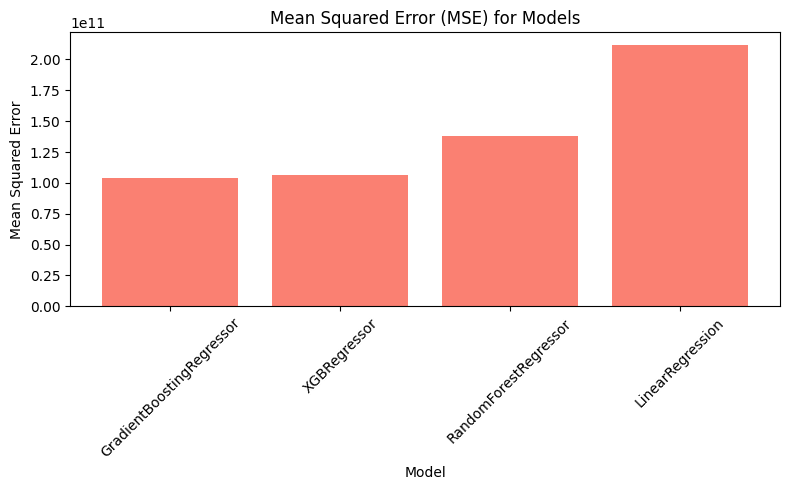

In [3]:
# Plot the histogram for Mean Squared Error (MSE)


plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['MSE'], color='salmon')
plt.title('Mean Squared Error (MSE) for Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

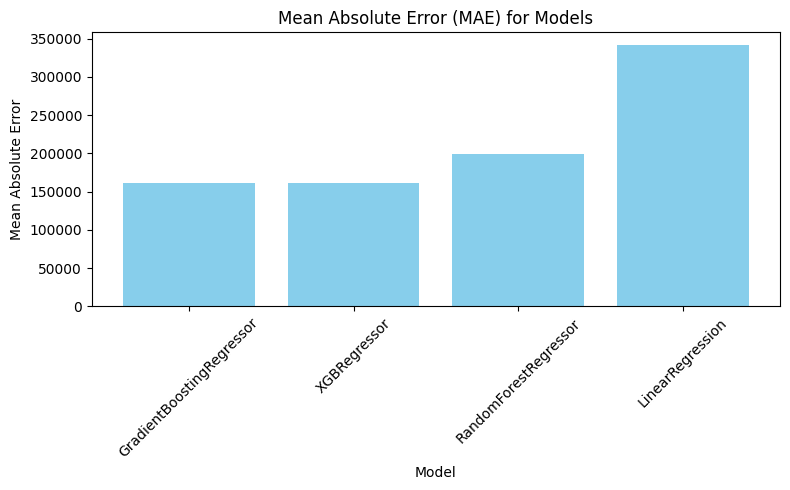

In [4]:
# Plot the histogram for Mean Absolute Error (MAE)
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['MAE'], color='skyblue')
plt.title('Mean Absolute Error (MAE) for Models')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

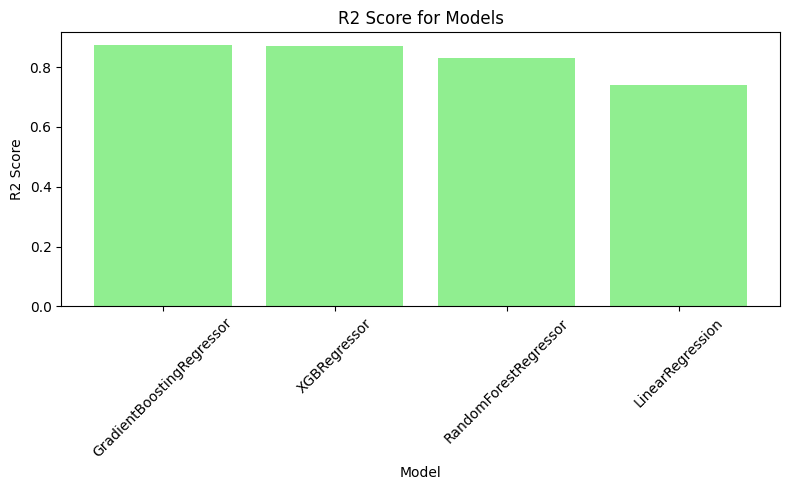

In [5]:
# Plot the histogram for R2 Score
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['R2 Score'], color='lightgreen')
plt.title('R2 Score for Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

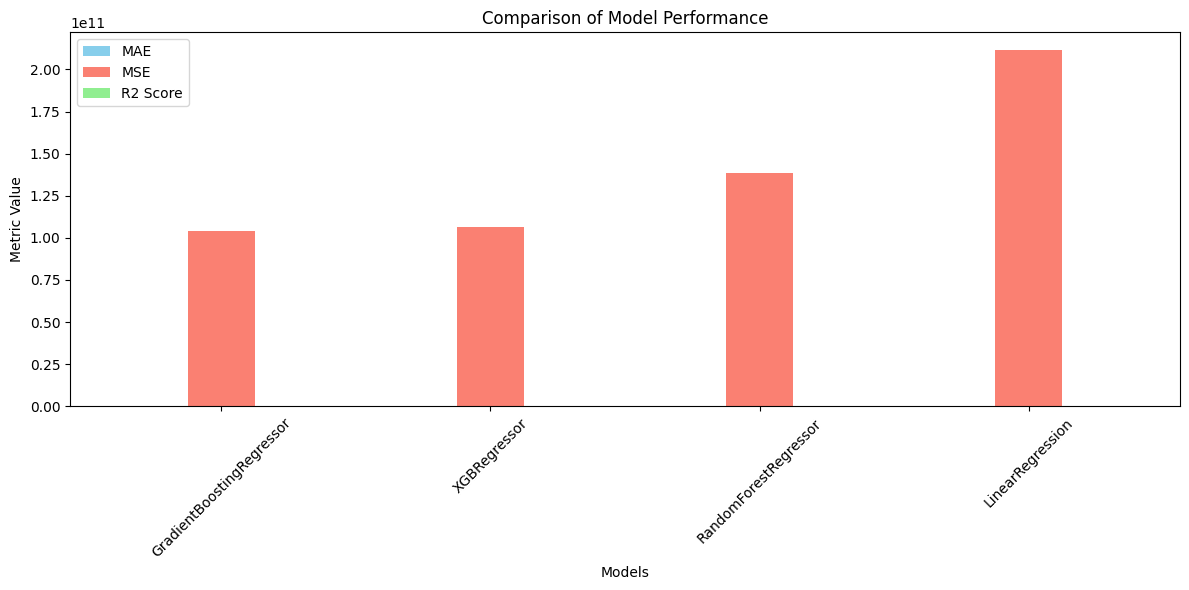

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare data for visualization
metrics = ['MAE', 'MSE', 'R2 Score']
x = np.arange(len(results['Model'])) # the label locations
width = 0.25 # the width of the bars
# Plot the metrics for each model
fig, ax = plt.subplots(figsize=(12, 6))
# Create bars for each metric
bars1 = ax.bar(x - width, results['MAE'], width, label='MAE', color='skyblue')
bars2 = ax.bar(x, results['MSE'], width, label='MSE', color='salmon')
bars3 = ax.bar(x + width, results['R2 Score'], width, label='R2 Score', color='lightgreen')
# Add labels, title, and custom ticks



ax.set_xlabel('Models')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'], rotation=45)
ax.set_ylabel('Metric Value')
ax.legend()
# Display the plot
plt.tight_layout()
plt.show()

                       Model            MAE           MSE  R2 Score
2  GradientBoostingRegressor  160723.882049  1.038593e+11  0.873009
3               XGBRegressor  161536.296875  1.066916e+11  0.869546
1      RandomForestRegressor  198925.000000  1.382364e+11  0.830976
0           LinearRegression  341367.739172  2.114340e+11  0.741476
4      DecisionTreeRegressor  262500.000000  2.493750e+11  0.695085


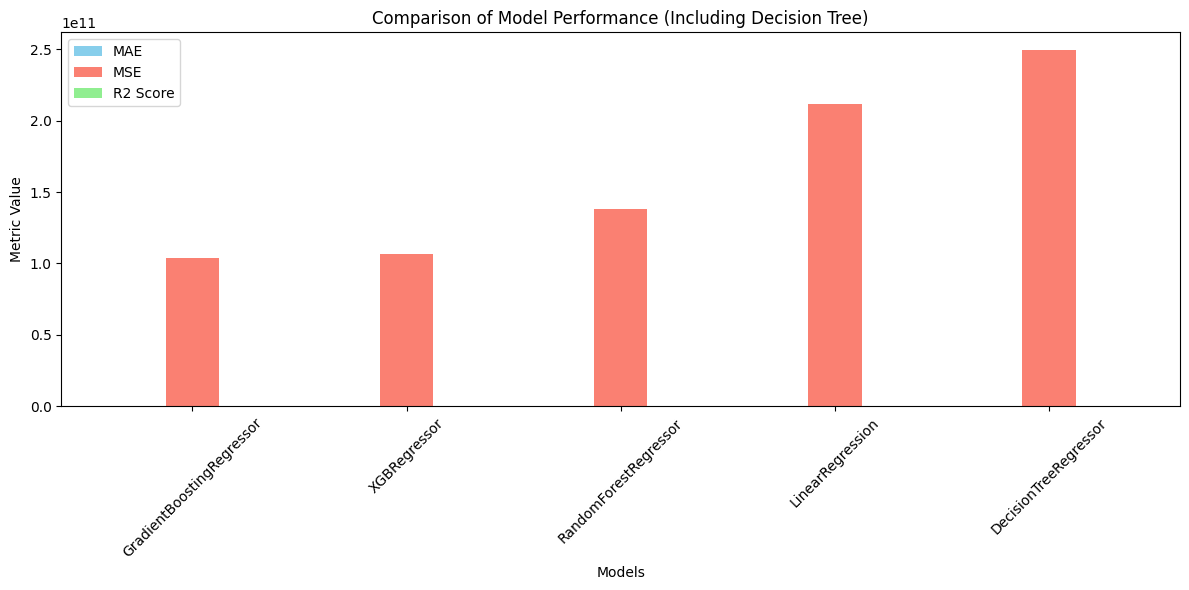

In [7]:
from sklearn.tree import DecisionTreeRegressor
# Add Decision Tree Regressor to the models list
models = [
LinearRegression(),
RandomForestRegressor(random_state=42),
GradientBoostingRegressor(random_state=42),
XGBRegressor(random_state=42),
DecisionTreeRegressor(random_state=42)
]
# Evaluate all models
results = pd.DataFrame([evaluate_model(model) for model in models])



# Sort the results by R2 Score
results.sort_values(by='R2 Score', ascending=False, inplace=True)
# Display the results
print(results)
# Visualize the comparison
import matplotlib.pyplot as plt
import numpy as np
# Prepare data for visualization
metrics = ['MAE', 'MSE', 'R2 Score']
x = np.arange(len(results['Model'])) # the label locations
width = 0.25 # the width of the bars
# Plot the metrics for each model
fig, ax = plt.subplots(figsize=(12, 6))
# Create bars for each metric
bars1 = ax.bar(x - width, results['MAE'], width, label='MAE', color='skyblue')
bars2 = ax.bar(x, results['MSE'], width, label='MSE', color='salmon')
bars3 = ax.bar(x + width, results['R2 Score'], width, label='R2 Score', color='lightgreen')
# Add labels, title, and custom ticks
ax.set_xlabel('Models')
ax.set_title('Comparison of Model Performance (Including Decision Tree)')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'], rotation=45)
ax.set_ylabel('Metric Value')
ax.legend()
# Display the plot
plt.tight_layout()
plt.show()